# Run eQTL analysis for lupus data

In [3]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os
import pickle as pkl
%matplotlib inline

In [4]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [5]:
data_path  = '/data_volume/memento/lupus/'

### Read SNP positions

In [4]:
pos = pd.read_csv(data_path + 'cm_cg.genos', sep='\t', index_col=0)

In [5]:
pos = pos[~pos.index.duplicated(keep='first')]

In [6]:
# Filter for lupus patients
pos = pos[[c for c in pos.columns if 'HC' not in c]]

### Read mat eQTL output

In [7]:
cbc_eqtls = pd.read_csv(data_path + 'Table6.txt', sep='\t', skiprows=1).query('cell == "cm"').drop('STD_FE', axis=1)
cbc_eqtls.columns = ['ct', 'rsid_gene', 'pvalue', 'beta']

In [8]:
cbc_eqtls['gene'] = cbc_eqtls['rsid_gene'].str.split('_').str[1]
cbc_eqtls['rsid'] = cbc_eqtls['rsid_gene'].str.split('_').str[0]

In [9]:
cbc_eqtls = cbc_eqtls[cbc_eqtls['rsid'].isin(pos.index)]

In [10]:
cbc_eqtls = cbc_eqtls.sample(10000)

### Read the lupus data and filter for genotyped donors and cell type

In [11]:
# adata = sc.read(data_path + 'Lupus_study_adjusted.h5ad')
# adata_counts = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs)
# adata_counts.write(data_path + 'Lupus_study_adjusted_counts.h5ad')

### Compare donor resampling vs not

In [12]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts_cM_filtered.h5ad')
adata = adata[adata.obs.ind_cov.isin(pos.columns)].copy()
# adata.obs['ind_cov'] = np.random.choice(['d'+str(i) for i in range(30)], size=adata.shape[0])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
donors = adata.obs[['ind_cov']].drop_duplicates()
donors.index = np.arange(donors.shape[0])
donors['tx'] = np.random.choice([-1, 1], donors.shape[0])

In [14]:
adata.obs['capture_rate'] = 0.1
# adata.obs['tx'] = np.random.choice([-1, 1], size=adata.shape[0])
adata.obs = adata.obs.merge(donors, on='ind_cov', how='left')
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.01)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


In [15]:
# adata.obs['tx'] = np.random.randint(2, size=adata.shape[0])

In [16]:
adata.obs.head(2)

,batch_cov,ind_cov,Processing_Cohort,louvain,cg_cov,ct_cov,L3,ind_cov_batch_cov,Age,Sex,pop_cov,Status,SLE_status,capture_rate,tx,memento_size_factor
0,dmx_flare2,1791_1791,3.0,0,cM,NaN,0.0,1791_1791:dmx_flare2,66.0,Female,Asian,Managed,SLE,0.1,-1,0.840621
1,dmx_YE_7-26,1240_1240,2.0,7,cM,NaN,0.0,1240_1240:dmx_YE_7-26,23.0,Female,Asian,Managed,SLE,0.1,-1,1.143437


In [22]:
# Grouped by individual
adata1 = adata.copy().copy()
memento.create_groups(adata1, label_columns=['tx','ind_cov'])
memento.compute_1d_moments(adata1, min_perc_group=.5, gene_list=cbc_eqtls.gene.drop_duplicates().tolist())
treatment_df= pd.DataFrame(index=adata1.uns['memento']['groups'])
treatment_df['tx'] = treatment_df.index.str.split('^').str[1].astype(float)
memento.ht_1d_moments(
    adata1, 
    covariate=pd.DataFrame(np.ones(treatment_df.shape[0]).reshape(-1, 1)),
    treatment=treatment_df,
#     treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=True,
    resample_rep=True)
memento_result1 = memento.get_1d_ht_result(adata1)


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.2s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   10.0s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   22.3s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   37.8s
[Parallel(n_jobs=94)]: Done 1333 out of 1333 | elapsed:  1.0min finished


(array([886.,  71.,  74.,  61.,  34.,  54.,  27.,  43.,  46.,  37.]),
 array([0.        , 0.09970178, 0.19940356, 0.29910534, 0.39880712,
        0.49850889, 0.59821067, 0.69791245, 0.79761423, 0.89731601,
        0.99701779]),
 <BarContainer object of 10 artists>)

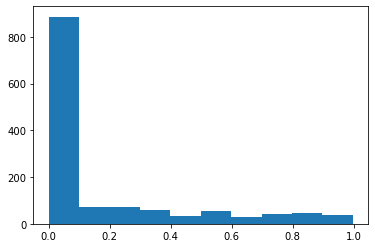

In [21]:
plt.hist(memento_result1['de_pval'], bins=10)

(array([117., 144., 145., 122., 129., 129., 122., 146., 140., 139.]),
 array([9.00283283e-04, 1.00720030e-01, 2.00539777e-01, 3.00359524e-01,
        4.00179271e-01, 4.99999018e-01, 5.99818765e-01, 6.99638512e-01,
        7.99458258e-01, 8.99278005e-01, 9.99097752e-01]),
 <BarContainer object of 10 artists>)

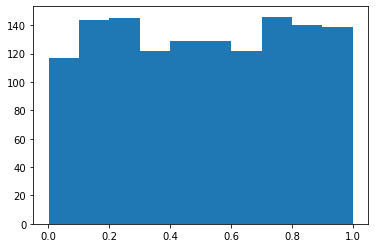

In [24]:
plt.hist(memento_result1['de_pval'], bins=10)

### Run memento for cbc eQTLs - debug whats going on

In [12]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts_cM_filtered.h5ad')
adata = adata[adata.obs.ind_cov.isin(pos.columns)].copy()
# adata.obs['ind_cov'] = np.random.choice(['d'+str(i) for i in range(30)], size=adata.shape[0])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
donors = adata.obs[['ind_cov']].drop_duplicates()
donors.index = np.arange(donors.shape[0])
# donors['tx'] = np.random.choice([-1, 1], donors.shape[0])

In [15]:
adata.obs['capture_rate'] = 0.1
# adata.obs['tx'] = np.random.choice([-1, 1], size=adata2.shape[0])
adata.obs = adata.obs.merge(donors, on='ind_cov', how='left')
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.01)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


In [16]:
# adata.obs['tx'] = np.random.randint(2, size=adata.shape[0])

In [17]:
# Grouped by individual
adata1 = adata.copy().copy()
memento.create_groups(adata1, label_columns=['ind_cov'])
memento.compute_1d_moments(adata1, min_perc_group=.5, gene_list=cbc_eqtls.gene.drop_duplicates().tolist())
treatment_df= pd.DataFrame(index=adata1.uns['memento']['groups'])
treatment_df['tx'] = treatment_df.index.str.split('^').str[1].astype(float)
memento.ht_1d_moments(
    adata1, 
    covariate=pd.DataFrame(np.ones(treatment_df.shape[0]).reshape(-1, 1)),
    treatment=treatment_df,
#     treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False,
    resample_rep=True)
memento_result1 = memento.get_1d_ht_result(adata1)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    8.1s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   15.8s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   27.9s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   43.0s
[Parallel(n_jobs=94)]: Done 1358 out of 1358 | elapsed:  1.1min finished


In [18]:
# Grouped by individual
adata2 = adata.copy().copy()
memento.create_groups(adata2, label_columns=['tx'])
memento.compute_1d_moments(adata2, min_perc_group=.5, gene_list=cbc_eqtls.gene.drop_duplicates().tolist())
treatment_df= pd.DataFrame(index=adata2.uns['memento']['groups'])
treatment_df['tx'] = treatment_df.index.str.split('^').str[1].astype(float)
memento.ht_1d_moments(
    adata2, 
    covariate=pd.DataFrame(np.ones(2).reshape(-1, 1)),
    treatment=treatment_df,
#     treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)
memento_result2 = memento.get_1d_ht_result(adata2)


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=94)]: Done 340 tasks      | elapsed:    1.9s
[Parallel(n_jobs=94)]: Done 1030 tasks      | elapsed:    5.3s
[Parallel(n_jobs=94)]: Done 1179 out of 1366 | elapsed:    5.9s remaining:    0.9s
[Parallel(n_jobs=94)]: Done 1366 out of 1366 | elapsed:   10.1s finished


In [19]:
memento_result2.head(2)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,HES4,tx,0.081075,0.019196,0.001552,0.085401,0.045807,0.063994
1,SSU72,tx,0.024740,0.006117,0.000367,0.021376,0.036374,0.558144


In [20]:
memento_result1.head(2)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,HES4,tx,0.095975,0.027934,0.001585,0.137013,0.051919,0.007299
1,SSU72,tx,0.022305,0.006318,0.002604,0.025696,0.046818,0.568343


In [ ]:
plt.hist(memento_result2['dv_pval'], bins=20)

(array([172.,  92.,  78.,  71.,  57.,  66.,  64.,  69.,  53.,  61.,  61.,
         59.,  55.,  55.,  60.,  68.,  57.,  34.,  54.,  72.]),
 array([5.06893060e-06, 4.99648195e-02, 9.99245700e-02, 1.49884321e-01,
        1.99844071e-01, 2.49803822e-01, 2.99763572e-01, 3.49723323e-01,
        3.99683073e-01, 4.49642824e-01, 4.99602574e-01, 5.49562325e-01,
        5.99522076e-01, 6.49481826e-01, 6.99441577e-01, 7.49401327e-01,
        7.99361078e-01, 8.49320828e-01, 8.99280579e-01, 9.49240329e-01,
        9.99200080e-01]),
 <BarContainer object of 20 artists>)

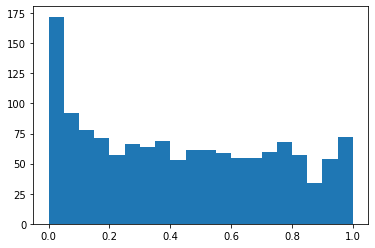

In [23]:
plt.hist(memento_result1['dv_pval'], bins=20)

In [52]:
memento_result2.head(2)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,HES4,tx,-0.025783,0.019019,0.174483,0.029507,0.045868,0.524748
1,SSU72,tx,0.009502,0.006119,0.123288,0.001534,0.035874,0.965003


In [282]:
adata.shape

(89925, 32738)

In [283]:
# memento.compute_1d_moments(adata, min_perc_group=.5)

In [284]:
memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=cbc_eqtls.gene.drop_duplicates().tolist())

In [285]:
covariates = pd.read_csv(data_path + 'cm_cg.mateqtl_cov.txt', sep='\t', index_col=0).T
cov_df = covariates[['age', 'Female'] + [x for x in covariates.columns if '_g' in x]].loc[[x[3:] for x in adata.uns['memento']['groups']]]
cov_df['donor'] = cov_df.index.values
cov_df = pd.get_dummies(cov_df)

In [286]:
treatment_df = pd.DataFrame(index=adata.uns['memento']['groups'])

In [253]:
# treatment_df['tx'] = treatment_df.index.str.split('^').str[1].astype(float)

In [287]:
treatment_df = pd.DataFrame(np.random.choice([-1, 1], size=(cov_df.shape[0], 2)))
# treatment_df = pd.DataFrame([[1], [0], [2]])


In [288]:
memento.ht_1d_moments(
    adata, 
    covariate=pd.DataFrame(np.ones(treatment_df.shape[0]).reshape(-1, 1)),
    treatment=treatment_df,
#     treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)

[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  13 tasks      | elapsed:   11.1s
[Parallel(n_jobs=94)]: Done 263 tasks      | elapsed:   19.9s
[Parallel(n_jobs=94)]: Done 613 tasks      | elapsed:   32.5s
[Parallel(n_jobs=94)]: Done 1063 tasks      | elapsed:   49.5s
[Parallel(n_jobs=94)]: Done 1613 tasks      | elapsed:  1.2min
[Parallel(n_jobs=94)]: Done 1944 out of 1944 | elapsed:  1.6min finished


In [290]:
memento_result = memento.get_1d_ht_result(adata)


In [258]:
memento_result.query('tx == 0').sort_values('de_coef').head(2)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval


Text(0.5, 1.0, 'eQTL p-values with permutation 1')

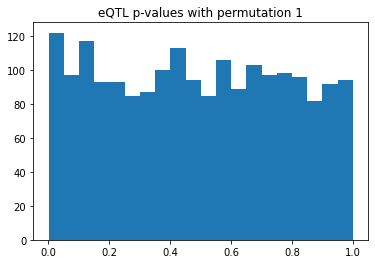

In [289]:
plt.hist(memento_result['de_pval'], bins=20)
plt.title('eQTL p-values with permutation 1')

Text(0.5, 1.0, 'eQTL p-values with permutation 2')

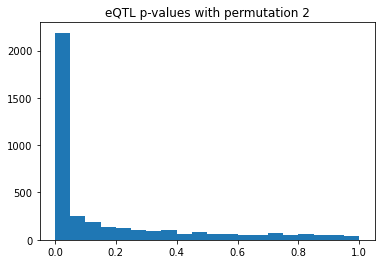

In [291]:
plt.hist(memento_result['de_pval'], bins=20)
plt.title('eQTL p-values with permutation 2')

In [182]:
df = pd.DataFrame()
df['tx'] = treatment_df[0].values
df['mean'] = memento.get_1d_moments(adata)[1].query('gene == "S100P"').values[0][1:]

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg/memento/main.py:528: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])


In [ ]:
stats.mannwhitneyu(df.query('tx==1')['mean'], df.query('tx==-1')['mean'])

<AxesSubplot:xlabel='tx', ylabel='mean'>

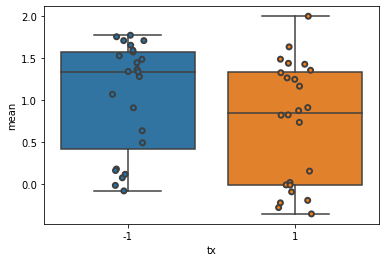

In [184]:
sns.boxplot(x='tx', y='mean', data=df)
sns.stripplot(x='tx', y='mean', data=df, linewidth=2)

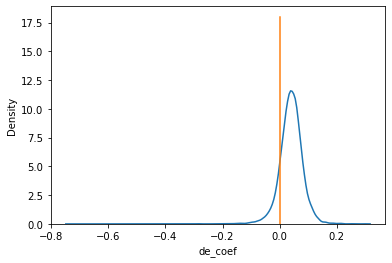

In [179]:
sns.kdeplot(memento_result.query('tx == 1')['de_coef'])
plt.plot([0, 0], [0, 18])

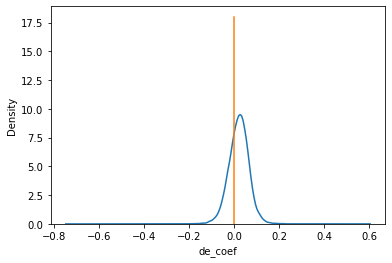

In [176]:
sns.kdeplot(memento_result['de_coef'])
plt.plot([0, 0], [0, 18])

In [ ]:
plt.hist(memento_result['de_pval'], bins=10);

In [142]:
memento_result

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,AL627309.1,0,-0.132129,0.054369,0.014099,-0.109140,0.082499,0.197180
1,AL627309.1,1,-0.135396,0.052860,0.012799,-0.028661,0.080185,0.728527
2,AP006222.2,0,0.152765,0.058304,0.008799,-0.201142,0.076129,0.006799
3,AP006222.2,1,-0.078853,0.054623,0.149685,0.073584,0.074079,0.334567
4,RP11-206L10.3,0,0.025615,0.072559,0.722028,-0.064250,0.061527,0.320368
...,...,...,...,...,...,...,...,...
16505,MT-CYB,1,-0.233286,0.005757,0.000032,0.059818,0.065730,0.378062
16506,AL592183.1,0,0.141936,0.025134,0.000758,-0.010413,0.090251,0.904410
16507,AL592183.1,1,-0.276548,0.023283,0.000002,0.211576,0.083545,0.012499
16508,SRSF10-1,0,0.438942,0.094298,0.000243,-0.026859,0.059642,0.672633


In [187]:
donor_df = pos[[x[3:] for x in adata.uns['memento']['groups']]].T

In [190]:
donor_df['1:713977'].value_counts()

0    37
1    10
2     1
Name: 1:713977, dtype: int64

In [189]:
donor_df['1:706368'].value_counts()

0    21
1    18
2     9
Name: 1:706368, dtype: int64

In [188]:
donor_df.head(2)

CHROM:POS,1:706368,1:713977,1:714439,1:723891,1:727655,1:729679,1:741267,1:751580,1:752242,1:752566,...,22:51186143,22:51186228,22:51192586,22:51197266,22:51208537,22:51210289,22:51211392,22:51212875,22:51219006,22:51237063
1791_1791,2,0,0,2,0,2,0,0,0,2,...,1,1,0,1,0,1,1,1,0,1
1240_1240,0,0,0,1,0,1,0,0,0,1,...,1,1,1,1,0,1,1,1,0,1


In [18]:
gene_to_snp = dict(cbc_eqtls[cbc_eqtls.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))
# gene_to_snp = {'HP':['16:72135014']}

In [23]:
np.random.randint(5, size=21000).max()

4

In [25]:
# donor_df[donor_df.columns] = np.random.randint(3, size=donor_df.shape)

In [70]:
donor_df = pd.DataFrame()
donor_df['tx'] = np.random.randint(2, size=cov_df.shape[0])

In [72]:
memento.ht_1d_moments(
    adata, 
    covariate=pd.DataFrame(np.ones(cov_df.shape[0]).reshape(-1, 1)),
    treatment=donor_df,
#     treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)

[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    8.0s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   17.0s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   29.3s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   45.9s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:  1.1min
[Parallel(n_jobs=94)]: Done 1944 out of 1944 | elapsed:  1.5min finished


In [73]:
memento_result = memento.get_1d_ht_result(adata).rename(columns={'tx':'rsid'})


<AxesSubplot:xlabel='de_coef', ylabel='Density'>

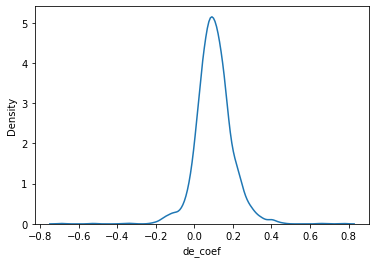

In [77]:
sns.kdeplot(memento_result['de_coef'])

In [75]:
memento_result

,gene,rsid,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,HES4,tx,0.218775,0.053809,3.236485e-04,-0.107955,0.103691,0.307769
1,SSU72,tx,0.062554,0.012637,8.826821e-04,-0.129384,0.094095,0.164584
2,LRRC47,tx,0.114076,0.036927,1.699830e-03,0.041390,0.068808,0.544346
3,KCNAB2,tx,0.119184,0.024204,8.861533e-05,-0.003177,0.095614,0.974603
4,ICMT,tx,0.044367,0.068866,5.175482e-01,-0.037150,0.081294,0.662934
...,...,...,...,...,...,...,...,...
1939,ITGB2,tx,0.312074,0.007514,9.535716e-09,-0.167875,0.047701,0.001200
1940,ITGB2-AS1,tx,0.103896,0.028800,9.332363e-04,-0.021745,0.087807,0.799020
1941,FAM207A,tx,0.084091,0.026994,1.699830e-03,0.153363,0.090927,0.091091
1942,YBEY,tx,-0.104484,0.032165,1.299870e-03,-0.038128,0.083970,0.649535


(array([1516.,  111.,   62.,   46.,   39.,   45.,   42.,   26.,   31.,
          26.]),
 array([9.53571602e-09, 9.95600526e-02, 1.99120096e-01, 2.98680139e-01,
        3.98240182e-01, 4.97800225e-01, 5.97360268e-01, 6.96920311e-01,
        7.96480354e-01, 8.96040397e-01, 9.95600440e-01]),
 <BarContainer object of 10 artists>)

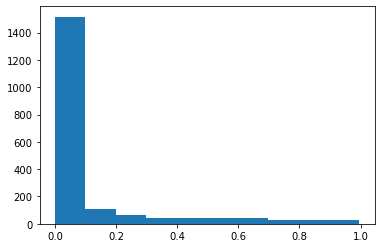

In [74]:
plt.hist(memento_result['de_pval'])

In [97]:
test = donor_df[['16:72165986']].copy()
test['mean'] = memento.get_1d_moments(adata)[0][['sg^' + x for x in test.index]].values.reshape(-1)

In [100]:
cov_df.head(2)

,age,Female,PC1_g,PC2_g,PC3_g,PC4_g,PC5_g,PC6_g,PC7_g,donor_1045_1045,...,donor_1743_1743,donor_1754_1754,donor_1763_1763,donor_1768_1768,donor_1771_1771,donor_1772_1772,donor_1791_1791,donor_1804_1804,donor_1888_1888,donor_2061_2061
1791_1791,66.0,0.0,0.0411,-0.0435,0.0348,0.0019,0.1033,-0.0919,0.0191,0,...,0,0,0,0,0,0,1,0,0,0
1240_1240,23.0,0.0,-0.0049,0.2181,-0.0730,-0.0005,-0.1076,0.0217,-0.0766,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
memento_result

,gene,rsid,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,HP,16:72135014,4.515063,0.158239,1.800353e-07,1.594096,0.333995,0.0002


In [ ]:
# memento_result.to_csv(data_path + 'cbc_eqtl_memento_cov_donor.csv', index=False)

### CBC eqtls

In [13]:
memento_nocov = pd.read_csv(data_path + 'cbc_eqtl_memento.csv')
memento_cov = pd.read_csv(data_path + 'cbc_eqtl_memento_cov.csv')

In [48]:
memento_result = memento_result.drop_duplicates(['de_coef'])

In [60]:
memento_result['de_fdr'] = memento.util._fdrcorrect(memento_result['de_pval'])

In [62]:
memento_result.query('de_fdr < 0.001').sort_values('de_coef')

,gene,rsid,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr
340,HLA-DRB5,6:32545816,-1.293518,0.042350,3.294199e-05,-0.231091,0.089692,0.009999,0.000664
8,S100P,4:6688349,-1.020019,0.116504,9.709989e-07,-0.408144,0.204250,0.046495,0.000142
399,HLA-DRB5,6:32554197,-0.991277,0.027831,1.933936e-07,-0.277704,0.066437,0.000404,0.000048
400,HLA-DRB5,6:32554197,-0.991277,0.027831,1.933936e-07,-0.277704,0.066437,0.000404,0.000048
401,HLA-DRB5,6:32554197,-0.991277,0.027831,1.933936e-07,-0.277704,0.066437,0.000404,0.000048
...,...,...,...,...,...,...,...,...,...
1,SIGLEC14,19:52119546,0.910100,0.086029,8.373470e-06,0.092016,0.099736,0.367763,0.000463
2,UTS2,1:7981453,0.948542,0.083829,2.808871e-05,0.121065,0.054670,0.026797,0.000652
252,HLA-DRB5,6:32502374,1.041936,0.018910,4.973360e-07,0.142334,0.052358,0.007799,0.000094
254,HLA-DRB5,6:32502465,1.085360,0.020431,6.310660e-07,0.255210,0.053597,0.000374,0.000108


In [67]:
df = pd.DataFrame()
df['geno'] = donor_df['1:7981453'].values
df['mean'] = memento.get_1d_moments(adata)[1].query('gene == "UTS2"').values[0][1:]

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg/memento/main.py:528: RuntimeWarning: divide by zero encountered in log


<AxesSubplot:xlabel='geno', ylabel='mean'>

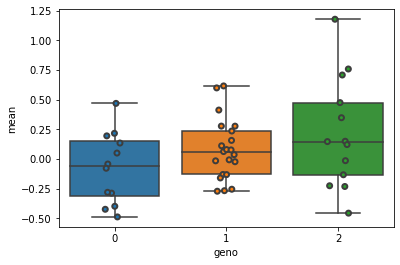

In [68]:
sns.boxplot(x='geno', y='mean', data=df)
sns.stripplot(x='geno', y='mean', data=df, linewidth=2)

(array([20873.,  9354.,  8845.,  7939.,  8317.,  7149.,  6928.,  6730.,
         6517.,  7145.]),
 array([2.54011199e-07, 1.00000229e-01, 2.00000203e-01, 3.00000178e-01,
        4.00000152e-01, 5.00000127e-01, 6.00000102e-01, 7.00000076e-01,
        8.00000051e-01, 9.00000025e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

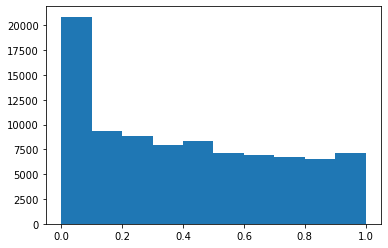

In [54]:
plt.hist(memento_result['dv_pval'])

In [18]:
memento_result = memento.get_1d_ht_result(adata).rename(columns={'tx':'rsid'})


In [19]:
merged = cbc_eqtls[['gene', 'rsid', 'beta', 'pvalue']].merge(memento_result[['gene', 'rsid', 'de_coef', 'de_pval']], on=['gene', 'rsid'])

Text(0.5, 0, 'mat eqtl -log(p)')

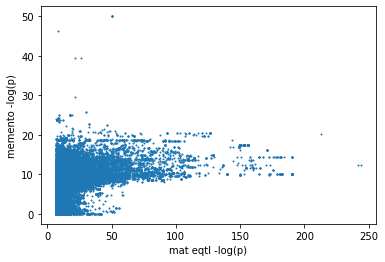

In [20]:
plt.scatter(-np.log(merged['pvalue']), -np.log(merged['de_pval']), s=1)
plt.ylabel('memento -log(p)'); plt.xlabel('mat eqtl -log(p)')
# plt.plot([0, 160], [0, 160], color='k')

In [21]:
merged.shape

(91517, 6)

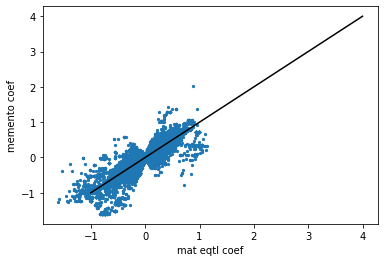

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2434: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2434: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2434: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


In [22]:
plt.scatter(merged['beta'], merged['de_coef'], s=5)
plt.xlabel('mat eqtl coef'); plt.ylabel('memento coef')
plt.plot([-1, 4], [-1, 4], color='k')

### Get SNP-gene pairs using bedtools

In [136]:
from pybedtools import BedTool

In [137]:
snppos = pd.read_csv(data_path + 'cm_cg.snpspos.txt', sep='\t')
snppos['chrom'] = snppos['chr']
snppos['pos_start'] = snppos['pos']
snppos['pos_end'] = snppos['pos']
snppos['rsid'] = snppos['snps']
snppos = snppos[['chrom', 'pos_start', 'pos_end', 'rsid']]

In [138]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [139]:
tss_df = enc.get_tss_window(window_size=0)


In [140]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts.h5ad')

In [141]:
tss_df = tss_df[tss_df['symbol'].isin(adata.var.index)]

In [142]:
tss_window_bed = BedTool.from_dataframe(tss_df)
snp_bed = BedTool.from_dataframe(snppos)

In [143]:
result = BedTool.window(tss_window_bed, snp_bed, w=1000000).to_dataframe()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [144]:
gene_snp_pairs = result[['name', 'itemRgb']].drop_duplicates().rename(columns={'name':'gene', 'itemRgb':'rsid'})

In [145]:
gene_snp_pairs.to_csv(data_path +'gene_snp_pairs.csv', index=False)


### Run memento on these gene-SNP pairs

In [13]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts_cM_filtered.h5ad')
adata = adata[adata.obs.ind_cov.isin(pos.columns)].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
gene_snp_pairs = pd.read_csv(data_path +'gene_snp_pairs.csv')

In [15]:
gene_snp_pairs.shape

(61007407, 2)

In [16]:
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.05)

In [17]:
memento.create_groups(adata, label_columns=['ind_cov'])

In [18]:
memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=gene_snp_pairs.gene.drop_duplicates().tolist())

In [19]:
gene_to_snp = dict(gene_snp_pairs[gene_snp_pairs.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))

In [20]:
donor_df = pos[[x[3:] for x in adata.uns['memento']['groups']]].T


In [ ]:
memento.ht_1d_moments(
    adata, 
    covariate=pd.DataFrame(np.ones((donor_df.shape[0], 1))),
    treatment=donor_df,
    treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=93,
    resampling='bootstrap',
    approx=False)


[Parallel(n_jobs=93)]: Using backend LokyBackend with 93 concurrent workers.
[Parallel(n_jobs=93)]: Done  14 tasks      | elapsed:  2.3min


In [ ]:
memento_result = memento.get_1d_ht_result(adata).rename(columns={'tx':'rsid'})


In [ ]:
memento_result.to_csv(data_path + 'cm_1M_result.csv')

In [78]:
df = pd.DataFrame()
df['geno'] = donor_df['1:78723333'].values
df['mean'] = memento.get_1d_moments(adata)[0].query('gene == "IFI44L"').values[0][1:]

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg/memento/main.py:528: RuntimeWarning: divide by zero encountered in log


<AxesSubplot:xlabel='geno', ylabel='mean'>

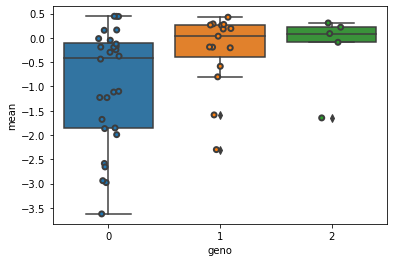

In [81]:
sns.boxplot(x='geno', y='mean', data=df)
sns.stripplot(x='geno', y='mean', data=df, linewidth=2)

(array([864464.,  82195.,  56765.,  45043.,  39514.,  36160.,  33252.,
         32488.,  31241.,  30480.]),
 array([2.56659725e-22, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

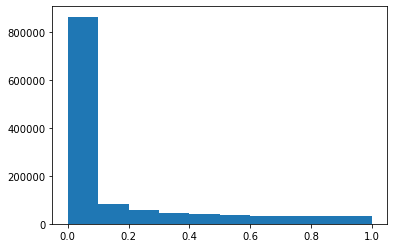

In [83]:
plt.hist(memento_result['de_pval'])

In [85]:
memento_result['fdr'] = memento.util._fdrcorrect(memento_result['de_pval'])

In [95]:
memento_result['bonf'] = np.clip(memento_result['de_pval']*memento_result.shape[0], a_max=1, a_min=0)

In [126]:
memento_result.query('fdr < 0.0007')

,gene,rsid,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,fdr,bonf
0,ISG15,1:901559,-0.393029,0.007668,1.649489e-05,0.288941,0.041399,0.000010,0.000451,1.000000
1,ISG15,1:901806,0.455740,0.008278,1.760721e-05,-0.280292,0.050265,0.000217,0.000462,1.000000
3,ISG15,1:903104,0.455740,0.008278,1.760721e-05,-0.280292,0.050265,0.000217,0.000462,1.000000
4,ISG15,1:903245,-0.096201,0.007067,5.834369e-07,0.193895,0.042357,0.000150,0.000107,0.730231
6,ISG15,1:904628,0.544886,0.009741,9.339878e-06,-0.352004,0.070797,0.000659,0.000362,1.000000
...,...,...,...,...,...,...,...,...,...,...
320,YBEY,21:46334076,-0.169987,0.023814,3.217665e-05,-0.081247,0.063568,0.201780,0.000574,1.000000
323,YBEY,21:46335282,-0.169987,0.023814,3.217665e-05,-0.081247,0.063568,0.201780,0.000574,1.000000
324,YBEY,21:46335370,-0.169987,0.023814,3.217665e-05,-0.081247,0.063568,0.201780,0.000574,1.000000
328,YBEY,21:46335940,0.159182,0.022925,3.384800e-05,0.086964,0.059917,0.177382,0.000583,1.000000


(array([822792.,  82530.,  60582.,  49784.,  42107.,  39842.,  38446.,
         37843.,  38917.,  38759.]),
 array([3.21235826e-16, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

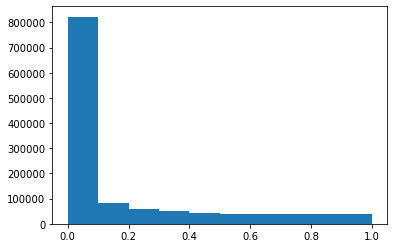

In [105]:
plt.hist(memento_result['fdr'])

In [97]:
memento_result.to_csv('cm_100k_result.csv', index=False)

In [ ]:
memento_result

In [93]:
memento_result.query('bonf < 0.1')#.shape[0]

,gene,rsid,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,fdr,bonf
15,ISG15,1:909419,0.326184,0.008495,2.838113e-08,-0.217460,0.054175,0.000755,0.000028,0.035522
26,ISG15,1:917640,0.456443,0.008639,4.701412e-08,-0.288429,0.054154,0.000081,0.000037,0.058843
27,ISG15,1:918238,0.456443,0.008639,4.701412e-08,-0.288429,0.054154,0.000081,0.000037,0.058843
47,ISG15,1:931362,0.148562,0.006978,8.689708e-09,-0.053943,0.043660,0.216778,0.000018,0.010876
59,ISG15,1:940005,0.148562,0.006978,8.689708e-09,-0.053943,0.043660,0.216778,0.000018,0.010876
...,...,...,...,...,...,...,...,...,...,...
207,ITGB2,21:44926759,-0.248446,0.006781,1.189126e-08,0.120146,0.042010,0.007099,0.000020,0.014883
208,ITGB2,21:44927015,-0.248446,0.006781,1.189126e-08,0.120146,0.042010,0.007099,0.000020,0.014883
209,ITGB2,21:44927089,-0.248446,0.006781,1.189126e-08,0.120146,0.042010,0.007099,0.000020,0.014883
211,ITGB2,21:44928863,-0.248446,0.006781,1.189126e-08,0.120146,0.042010,0.007099,0.000020,0.014883


In [14]:
onek_replication = pd.read_csv(data_path + 'OneK1K_eqtls_for_replication.txt', sep='\t')#.query('cell_type == "Mono_C"')

In [167]:
mapping = pd.read_csv('mart_export.txt', sep='\t')

In [168]:
mapping['rsid'] = mapping['Chromosome/scaffold name'].astype(str) + ':'+mapping['Chromosome/scaffold position start (bp)'].astype(str)

In [169]:
onek_replication = onek_replication.merge(mapping[['Variant name', 'rsid']], left_on='SNP_rsID', right_on='Variant name')

In [170]:
onek_replication['gene'] = onek_replication['GeneID']

In [171]:
gene_snp_pairs.query('gene == "LIPA"').query('rsid == "10:89243047"')

,gene,rsid


In [178]:
onek_replication.merge(cbc_eqtls, on=['rsid', 'gene'])

,GeneID,Gene_EnsemblID,SNP_rsID,SNP_assessed_allele,cell_type,Variant name,rsid,gene,ct,rsid_gene,pvalue,beta
0,BSG,ENSG00000172270,rs11085113,A,Mono_C,rs11085113,19:563613,BSG,cm,19:563613_BSG,1.106830e-12,-0.119617
1,CD151,ENSG00000177697,rs61876748,G,CD8_S100B,rs61876748,11:833262,CD151,cm,11:833262_CD151,8.864540e-36,0.436573
2,CD151,ENSG00000177697,rs61876748,G,Mono_C,rs61876748,11:833262,CD151,cm,11:833262_CD151,8.864540e-36,0.436573
3,POLR2L,ENSG00000177700,rs28404903,C,Mono_C,rs28404903,11:841763,POLR2L,cm,11:841763_POLR2L,1.163480e-11,-0.126476
4,TSPAN4,ENSG00000214063,rs28681202,T,Mono_C,rs28681202,11:834098,TSPAN4,cm,11:834098_TSPAN4,1.908820e-05,-0.122398


In [148]:
onek_replication['SNP_rsID'].drop_duplicates().shape

(619,)

In [180]:
memento_result['logp'] = -np.log(memento_result['de_pval'])

In [189]:
cbc_eqtls['logp'] = -np.log(cbc_eqtls['pvalue'])

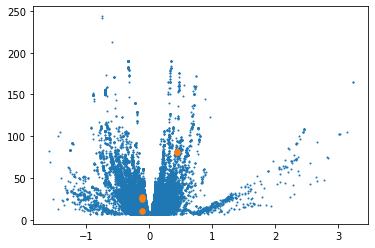

In [191]:
plt.scatter(cbc_eqtls['beta'], cbc_eqtls['logp'], s=1)
plt.scatter(cbc_eqtls.merge(onek_replication, on=['rsid', 'gene'])['beta'], cbc_eqtls.merge(onek_replication, on=['rsid', 'gene'])['logp'], s=30)

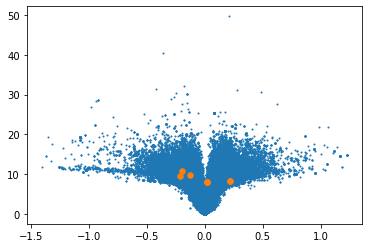

In [187]:
plt.scatter(memento_result['de_coef'], memento_result['logp'], s=1)
plt.scatter(memento_result.merge(onek_replication, on=['rsid', 'gene'])['de_coef'], memento_result.merge(onek_replication, on=['rsid', 'gene'])['logp'], s=30)

In [58]:
pv_sorted = memento_result['de_pval'].sort_values().values

In [59]:
quantiles = stats.uniform.ppf(np.linspace(0, 1, pv_sorted.shape[0]), loc=0, scale=1)

In [69]:
memento_result.sort_values('de_pval').head(15)

,gene,rsid,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
442,IFITM3,11:388579,0.232644,0.004755,0.0,-0.060880,0.007404,6.479226e-16
602,HLA-A,6:29940786,-0.130467,0.001955,0.0,0.174388,0.008243,5.491812e-98
117,RPS29,14:49619292,0.054916,0.001204,0.0,0.006312,0.004017,5.070637e-01
130,FCN1,9:134994132,0.189242,0.004768,0.0,0.036560,0.005654,1.595097e-10
128,FCN1,9:134988891,0.196267,0.004908,0.0,0.039881,0.005799,1.232455e-11
127,FCN1,9:134987645,0.161355,0.004037,0.0,0.045614,0.004731,2.861317e-21
124,FCN1,9:134984343,0.196267,0.004908,0.0,0.039881,0.005799,1.232455e-11
123,FCN1,9:134983511,-0.218136,0.004887,0.0,-0.000074,0.005970,9.902710e-01
122,FCN1,9:134981803,0.196267,0.004908,0.0,0.039881,0.005799,1.232455e-11
121,FCN1,9:134980361,0.196267,0.004908,0.0,0.039881,0.005799,1.232455e-11


### 1K1K replication

In [10]:
onek1k_pos = pd.read_csv('1k1k_snps_chrpos.txt', header=None).iloc[:,0].tolist()
onek1k_info = pd.read_csv('1k1k_snp_info.txt', sep='\t', header=None).iloc[:,:3]
onek1k_info.columns = ['chr', 'pos', 'name']
onek1k_info['rsid'] = onek1k_info['chr'].astype(str) + ':' + onek1k_info['pos'].astype(str)

In [37]:
onek_replication = pd.read_csv(data_path + 'OneK1K_eqtls_for_replication.txt', sep='\t')#.query('cell_type == "Mono_C"')

In [38]:
onek_replication = onek_replication.merge(onek1k_info, left_on='SNP_rsID', right_on='name').query('cell_type == "Mono_C"')

In [39]:
cbc_eqtls.head(2)

,ct,rsid_gene,pvalue,beta,gene,rsid
284295,cm,10:100122640_HPS1,0.000773,-0.066580,HPS1,10:100122640
284296,cm,10:100156113_HPS1,0.000105,-0.072121,HPS1,10:100156113


In [40]:
cbc_overlap = onek_replication

In [41]:
onek_replication['gene'] = onek_replication['GeneID']

In [42]:
onek_replication.head(2)

,GeneID,Gene_EnsemblID,SNP_rsID,SNP_assessed_allele,cell_type,chr,pos,name,rsid,gene
38,TIMM10,ENSG00000134809,rs2848626,T,Mono_C,11,57283988,rs2848626,11:57283988,TIMM10
45,RPLP2,ENSG00000177600,rs12277141,C,Mono_C,11,798865,rs12277141,11:798865,RPLP2


In [45]:
cbc_eqtls.shape

(98063, 6)

In [48]:
onek_replication.merge(cbc_eqtls, on=['gene', 'rsid']).shape

(213, 14)

In [65]:
memento_result.shape

(1251602, 10)

In [60]:
memento_result = pd.read_csv('cm_100k_result.csv').sort_values('de_coef')#.head(98063)

In [61]:
onek_replication.merge(memento_result, on=['gene', 'rsid']).shape

(60, 18)

In [59]:
onek_replication.head(2)

,GeneID,Gene_EnsemblID,SNP_rsID,SNP_assessed_allele,cell_type,chr,pos,name,rsid,gene
38,TIMM10,ENSG00000134809,rs2848626,T,Mono_C,11,57283988,rs2848626,11:57283988,TIMM10
45,RPLP2,ENSG00000177600,rs12277141,C,Mono_C,11,798865,rs12277141,11:798865,RPLP2


In [11]:
overlap = set(onek1k_info['rsid']) & set(pos.index.tolist())

In [12]:
len(overlap)

8086

In [13]:
hits_snps = set(onek_replication.rsid.tolist())

NameError: name 'onek_replication' is not defined

In [ ]:
set(overlap) & set(hits_snps)

In [245]:
onek_replication.query('rsid in @overlap')

,GeneID,Gene_EnsemblID,SNP_rsID,SNP_assessed_allele,cell_type,Variant name,rsid,gene
10,RPLP2,ENSG00000177600,rs12277141,C,B_Imm_Naïve,rs12277141,11:798865,RPLP2
11,RPLP2,ENSG00000177600,rs12277141,C,CD4_SOX4,rs12277141,11:798865,RPLP2
12,RPLP2,ENSG00000177600,rs12277141,C,Mono_C,rs12277141,11:798865,RPLP2
871,AC009005.2,ENSG00000267751,rs11085113,A,CD4_Naïve_CM,rs11085113,19:563613,AC009005.2
872,BSG,ENSG00000172270,rs11085113,A,Mono_C,rs11085113,19:563613,BSG
1170,CD151,ENSG00000177697,rs61876748,G,CD8_S100B,rs61876748,11:833262,CD151
1171,CD151,ENSG00000177697,rs61876748,G,Mono_C,rs61876748,11:833262,CD151
1270,POLR2L,ENSG00000177700,rs28404903,C,Mono_C,rs28404903,11:841763,POLR2L
1273,TSPAN4,ENSG00000214063,rs28681202,T,Mono_C,rs28681202,11:834098,TSPAN4
2072,IRF4,ENSG00000137265,rs72835945,G,Mono_C,rs72835945,6:580011,IRF4


### Test

In [7]:
adata = sc.read(data_path + 'Lupus_study_adjusted_counts.h5ad')
adata = adata[adata.obs.ind_cov.isin(pos.columns)].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
gene_snp_pairs = pd.read_csv(data_path +'gene_snp_pairs.csv')
gene_snp_pairs = gene_snp_pairs.query('gene == "IFITM3" & rsid == "11:388579"')

In [9]:
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.05)

In [10]:
memento.create_groups(adata, label_columns=['ind_cov'])

In [11]:
memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=['IFITM3'])

In [12]:
gene_to_snp = dict(gene_snp_pairs[gene_snp_pairs.gene.isin(adata.var.index)].groupby('gene').rsid.apply(list))

In [13]:
donor_df = pos[[x[3:] for x in adata.uns['memento']['groups']]].T


In [14]:
boot_mean = memento.ht_1d_moments(
    adata, 
    covariate=pd.DataFrame(np.ones((donor_df.shape[0], 1))),
    treatment=donor_df,
    treatment_for_gene=gene_to_snp,
    num_boot=10000, 
    verbose=1,
    num_cpus=1,
    resampling='bootstrap',
    approx=True)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s finished


In [20]:
from sklearn.linear_model import LinearRegression

In [24]:
coefs = LinearRegression().fit(donor_df[['11:388579']].values, boot_mean).coef_.reshape(-1)

In [27]:
coefs.shape

(10001,)

In [26]:
np.nanstd(coefs)

0.005181461719664188

<AxesSubplot:ylabel='Density'>

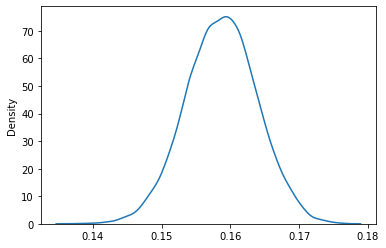

In [25]:
sns.kdeplot(coefs)

In [15]:
boot_mean

array([[-0.54370683, -0.52998624, -0.43924766, ..., -0.48863371,
        -0.56052675, -0.58236751],
       [-0.81346095, -0.83964215, -0.78934081, ..., -0.84336699,
        -0.80278802, -0.78686279],
       [-0.7383396 , -0.78514043, -0.6936486 , ..., -0.76877027,
        -0.70238199, -0.73656174],
       ...,
       [-0.24790595, -0.29927745, -0.28821551, ..., -0.2880716 ,
        -0.20381805, -0.24684751],
       [ 1.26190019,  1.27466918,  1.27960155, ...,  1.26140971,
         1.26621201,  1.25129435],
       [-0.22283186, -0.22971109, -0.21758006, ..., -0.22814172,
        -0.27817472, -0.24875275]])

In [83]:
memento.get_1d_ht_result(adata).rename(columns={'tx':'rsid'})

,gene,rsid,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,IFITM3,11:388579,0.232644,0.004767,0.0,-0.06088,0.00747,1.082898e-15


In [62]:
-np.log(pv_sorted)

/tmp/ipykernel_35644/277468987.py:1: RuntimeWarning: divide by zero encountered in log
  -np.log(pv_sorted)


array([           inf,            inf,            inf, ...,
       1.11886346e-05, 1.09539728e-05, 3.73659108e-06])

/tmp/ipykernel_35644/4198341462.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(-np.log(quantiles), -np.log(pv_sorted))


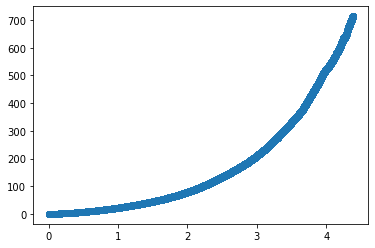

In [60]:
plt.scatter(-np.log(quantiles), -np.log(pv_sorted))

In [42]:
quantiles

array([0.00000000e+00, 3.78014953e-07, 7.56029906e-07, ...,
       9.99999244e-01, 9.99999622e-01, 1.00000000e+00])

In [ ]:
pv_

In [34]:
memento_result['de_pval']

0      1.205114e-03
1      9.861542e-05
2      6.550909e-05
3      4.849084e-05
4      9.861542e-05
           ...     
465    3.269799e-01
466    2.564196e-03
467    2.254359e-03
468    2.163161e-11
469    1.293189e-31
Name: de_pval, Length: 2645399, dtype: float64

### P-value histogram

In [1]:
import pandas as pd

In [6]:
result = pd.read_csv(data_path + 'window_100k/100k_result.csv', index_col=0)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
mateqtl_result = pd.r

In [14]:
theoretical = -np.log10(np.linspace(1e-9, 1, result.shape[0]))
actual = -np.log10(result['de_pval'].sort_values().values)

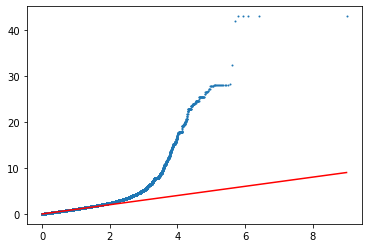

In [16]:
plt.scatter(theoretical, actual, s=1)
plt.plot(theoretical, theoretical, color='r')

In [20]:
mateqtl_output = pd.read_csv(data_path + 'mateqtl_output/cm_cg_mateqtl_cis_cov.out', sep='\t')
mateqtl_output['hit_id'] = mateqtl_output['gene'] + '*' + mateqtl_output['SNP']
# mateqtl_output['onek_valid'] = mateqtl_output['hit_id'].isin(onek_replication['hit_id'])
mateqtl_output['pvalue'] = mateqtl_output['p-value']

In [22]:
theoretical_meq = -np.log10(np.linspace(1e-9, 1, mateqtl_output.shape[0]))
actual_meq = -np.log10(mateqtl_output['p-value'].sort_values().values)

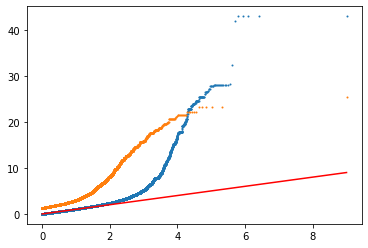

In [24]:
plt.scatter(theoretical, actual, s=1)
plt.scatter(theoretical_meq, actual_meq, s=1)
plt.plot(theoretical, theoretical, color='r')

